In [1]:
# Source: https://github.com/SohierDane/BigQuery_Helper/tree/master

"""
Helper class to simplify common read-only BigQuery tasks.
"""


import pandas as pd
import time

from google.cloud import bigquery




class BigQueryHelper(object):
    """
    Helper class to simplify common BigQuery tasks like executing queries,
    showing table schemas, etc without worrying about table or dataset pointers.

    See the BigQuery docs for details of the steps this class lets you skip:
    https://googlecloudplatform.github.io/google-cloud-python/latest/bigquery/reference.html
    """

    def __init__(self, active_project, dataset_name, max_wait_seconds=180):
        self.project_name = active_project
        self.dataset_name = dataset_name
        self.max_wait_seconds = max_wait_seconds
        self.client = bigquery.Client()
        self.__dataset_ref = self.client.dataset(self.dataset_name, project=self.project_name)
        self.dataset = None
        self.tables = dict()  # {table name (str): table object}
        self.__table_refs = dict()  # {table name (str): table reference}
        self.total_gb_used_net_cache = 0
        self.BYTES_PER_GB = 2**30

    def __fetch_dataset(self):
        """
        Lazy loading of dataset. For example,
        if the user only calls `self.query_to_pandas` then the
        dataset never has to be fetched.
        """
        if self.dataset is None:
            self.dataset = self.client.get_dataset(self.__dataset_ref)

    def __fetch_table(self, table_name):
        """
        Lazy loading of table
        """
        self.__fetch_dataset()
        if table_name not in self.__table_refs:
            self.__table_refs[table_name] = self.dataset.table(table_name)
        if table_name not in self.tables:
            self.tables[table_name] = self.client.get_table(self.__table_refs[table_name])

    def __handle_record_field(self, row, schema_details, top_level_name=''):
        """
        Unpack a single row, including any nested fields.
        """
        name = row['name']
        if top_level_name != '':
            name = top_level_name + '.' + name
        schema_details.append([{
            'name': name,
            'type': row['type'],
            'mode': row['mode'],
            'fields': np.nan,

                               }])
        # float check is to dodge row['fields'] == np.nan
        if type(row.get('fields', 0.0)) == float:
            return None
        for entry in row['fields']:
            self.__handle_record_field(entry, schema_details, name)

    def __unpack_all_schema_fields(self, schema):
        """
        Unrolls nested schemas. Returns dataframe with one row per field,
        and the field names in the format accepted by the API.
        Results will look similar to the website schema, such as:
            https://bigquery.cloud.google.com/table/bigquery-public-data:github_repos.commits?pli=1

        Args:
            schema: DataFrame derived from api repr of raw table.schema
        Returns:
            Dataframe of the unrolled schema.
        """
        schema_details = []
        schema.apply(lambda row:
            self.__handle_record_field(row, schema_details), axis=1)
        result = pd.concat([pd.DataFrame.from_dict(x) for x in schema_details])
        result.reset_index(drop=True, inplace=True)
        del result['fields']
        return result

    def table_schema(self, table_name):
        """
        Get the schema for a specific table from a dataset.
        Unrolls nested field names into the format that can be copied
        directly into queries. For example, for the `github.commits` table,
        the this will return `committer.name`.

        This is a very different return signature than BigQuery's table.schema.
        """
        self.__fetch_table(table_name)
        raw_schema = self.tables[table_name].schema
        schema = pd.DataFrame.from_dict([x.to_api_repr() for x in raw_schema])
        # the api_repr only has the fields column for tables with nested data
        if 'fields' in schema.columns:
            schema = self.__unpack_all_schema_fields(schema)
        # Set the column order
        schema = schema[['name', 'type', 'mode']]
        return schema

    def list_tables(self):
        """
        List the names of the tables in a dataset
        """
        self.__fetch_dataset()
        return([x.table_id for x in self.client.list_tables(self.dataset)])

    def estimate_query_size(self, query):
        """
        Estimate gigabytes scanned by query.
        Does not consider if there is a cached query table.
        See https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs#configuration.dryRun
        """
        my_job_config = bigquery.job.QueryJobConfig()
        my_job_config.dry_run = True
        my_job = self.client.query(query, job_config=my_job_config)
        return my_job.total_bytes_processed / self.BYTES_PER_GB

    def query_to_pandas(self, query):
        """
        Execute a SQL query & return a pandas dataframe
        """
        my_job = self.client.query(query)
        start_time = time.time()
        while not my_job.done():
            if (time.time() - start_time) > self.max_wait_seconds:
                print("Max wait time elapsed, query cancelled.")
                self.client.cancel_job(my_job.job_id)
                return None
            time.sleep(0.1)
        # Queries that hit errors will return an exception type.
        # Those exceptions don't get raised until we call my_job.to_dataframe()
        # In that case, my_job.total_bytes_billed can be called but is None
        if my_job.total_bytes_billed:
            self.total_gb_used_net_cache += my_job.total_bytes_billed / self.BYTES_PER_GB
        return my_job.to_dataframe()

    def query_to_pandas_safe(self, query, max_gb_scanned=1):
        """
        Execute a query, but only if the query would scan less than `max_gb_scanned` of data.
        """
        query_size = self.estimate_query_size(query)
        if query_size <= max_gb_scanned:
            return self.query_to_pandas(query)
        msg = "Query cancelled; estimated size of {0} exceeds limit of {1} GB"
        print(msg.format(query_size, max_gb_scanned))

    def head(self, table_name, num_rows=5, start_index=None, selected_columns=None):
        """
        Get the first n rows of a table as a DataFrame.
        Does not perform a full table scan; should use a trivial amount of data as long as n is small.
        """
        self.__fetch_table(table_name)
        active_table = self.tables[table_name]
        schema_subset = None
        if selected_columns:
            schema_subset = [col for col in active_table.schema if col.name in selected_columns]
        results = self.client.list_rows(active_table, selected_fields=schema_subset,
            max_results=num_rows, start_index=start_index)
        results = [x for x in results]
        return pd.DataFrame(
            data=[list(x.values()) for x in results], columns=list(results[0].keys()))


In [2]:
bq_data = BigQueryHelper("bigquery-public-data", "google_analytics_sample")

In [ ]:
bq_data.list_tables()[:10]

['ga_sessions_20160801',
 'ga_sessions_20160802',
 'ga_sessions_20160803',
 'ga_sessions_20160804',
 'ga_sessions_20160805',
 'ga_sessions_20160806',
 'ga_sessions_20160807',
 'ga_sessions_20160808',
 'ga_sessions_20160809',
 'ga_sessions_20160810']

In [3]:
import pandas as pd
import numpy as np

bq_data.table_schema((bq_data.list_tables()[0]))['name'].tolist()

['visitorId',
 'visitNumber',
 'visitId',
 'visitStartTime',
 'date',
 'totals',
 'totals.visits',
 'totals.hits',
 'totals.pageviews',
 'totals.timeOnSite',
 'totals.bounces',
 'totals.transactions',
 'totals.transactionRevenue',
 'totals.newVisits',
 'totals.screenviews',
 'totals.uniqueScreenviews',
 'totals.timeOnScreen',
 'totals.totalTransactionRevenue',
 'totals.sessionQualityDim',
 'trafficSource',
 'trafficSource.referralPath',
 'trafficSource.campaign',
 'trafficSource.source',
 'trafficSource.medium',
 'trafficSource.keyword',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo',
 'trafficSource.adwordsClickInfo.campaignId',
 'trafficSource.adwordsClickInfo.adGroupId',
 'trafficSource.adwordsClickInfo.creativeId',
 'trafficSource.adwordsClickInfo.criteriaId',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.cu

In [ ]:
# Check the size of dataset

total_train_query = """
SELECT  COUNT(*) AS COUNT
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
"""

total_data = bq_data.query_to_pandas(total_train_query)
print('Total number of records in google analytics dataset:',total_data['COUNT'][0])

Total number of records in google analytics dataset: 903653


In [ ]:
bq_data.head(bq_data.list_tables()[0])

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,channelGrouping,socialEngagementType
0,None,1,1470046245,1470046245,20160801,"{'visits': 1, 'hits': 24, 'pageviews': 17, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Firefox', 'browserVersion': 'not ...","{'continent': 'Europe', 'subContinent': 'Weste...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",895954260133011192,None,Organic Search,Not Socially Engaged
1,None,1,1470084717,1470084717,20160801,"{'visits': 1, 'hits': 24, 'pageviews': 18, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Internet Explorer', 'browserVersi...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 13, 'minu...",0288478011259077136,None,Direct,Not Socially Engaged
2,None,3,1470078988,1470078988,20160801,"{'visits': 1, 'hits': 27, 'pageviews': 17, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Safari', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",6440789996634275026,None,Organic Search,Not Socially Engaged
3,None,4,1470075581,1470075581,20160801,"{'visits': 1, 'hits': 27, 'pageviews': 19, 'ti...","{'referralPath': '/', 'campaign': '(not set)',...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 11, 'minu...",8520115029387302083,None,Referral,Not Socially Engaged
4,None,30,1470099026,1470099026,20160801,"{'visits': 1, 'hits': 27, 'pageviews': 17, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 17, 'minu...",6792260745822342947,None,Organic Search,Not Socially Engaged


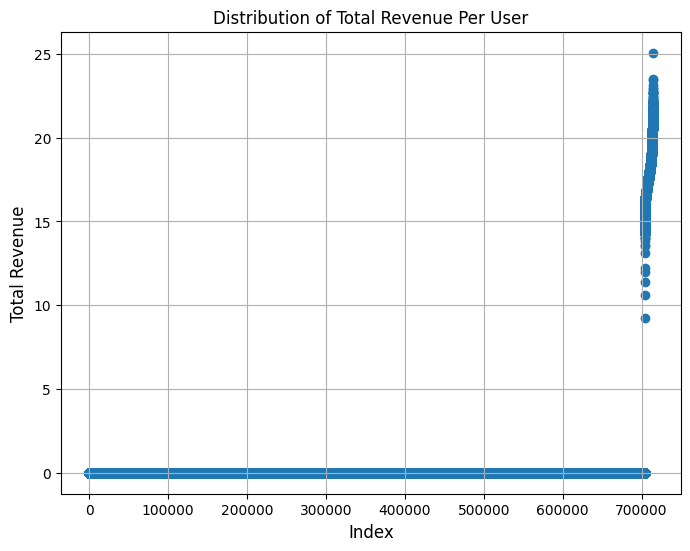

In [5]:
import matplotlib.pyplot as plt

totalrevenue_per_user_query = """
SELECT  fullVisitorId, coalesce(SUM( totals.transactionRevenue ),0) AS totalrevenue_per_user
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY fullVisitorId
"""
totalrevenue_per_user = bq_data.query_to_pandas_safe(totalrevenue_per_user_query)
plt.figure(figsize=(8,6))
# This creates a scatter plot where:
# The x-axis is the index of each data point (range(totalrevenue_per_user.shape[0]))
# The y-axis is the sorted, log-transformed total revenue per user.
# np.log1p() applies a log(1+x) transformation to handle zero values
# np.sort() sorts the values in ascending order
plt.scatter(range(totalrevenue_per_user.shape[0]), np.sort(np.log1p(totalrevenue_per_user["totalrevenue_per_user"].values)))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.title('Distribution of Total Revenue Per User')
plt.grid()
plt.show()

**Interpretation**
1. Small portion of users contribute the most of revenue. 


In [6]:
traindate_query = """
SELECT MIN(date) as startdate,MAX(date) as enddate
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
"""
traindate_result =  bq_data.query_to_pandas_safe(traindate_query)
print('Data in dataset is for date',traindate_result['startdate'].iloc[0],'to',traindate_result['enddate'].iloc[0])


Data in dataset is for date 20160801 to 20170801


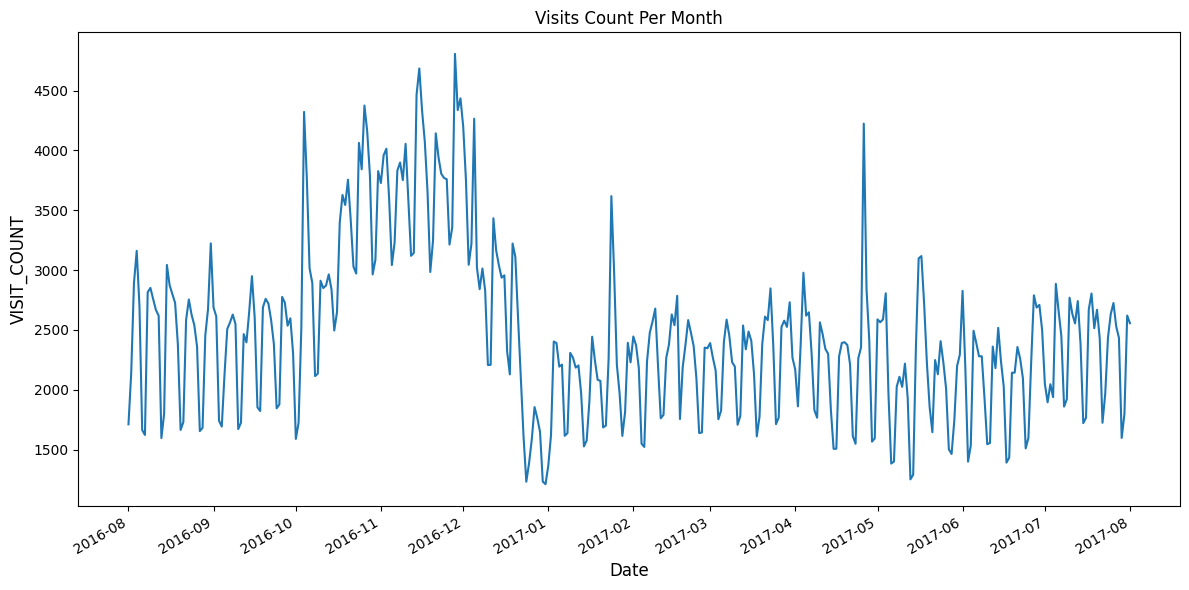

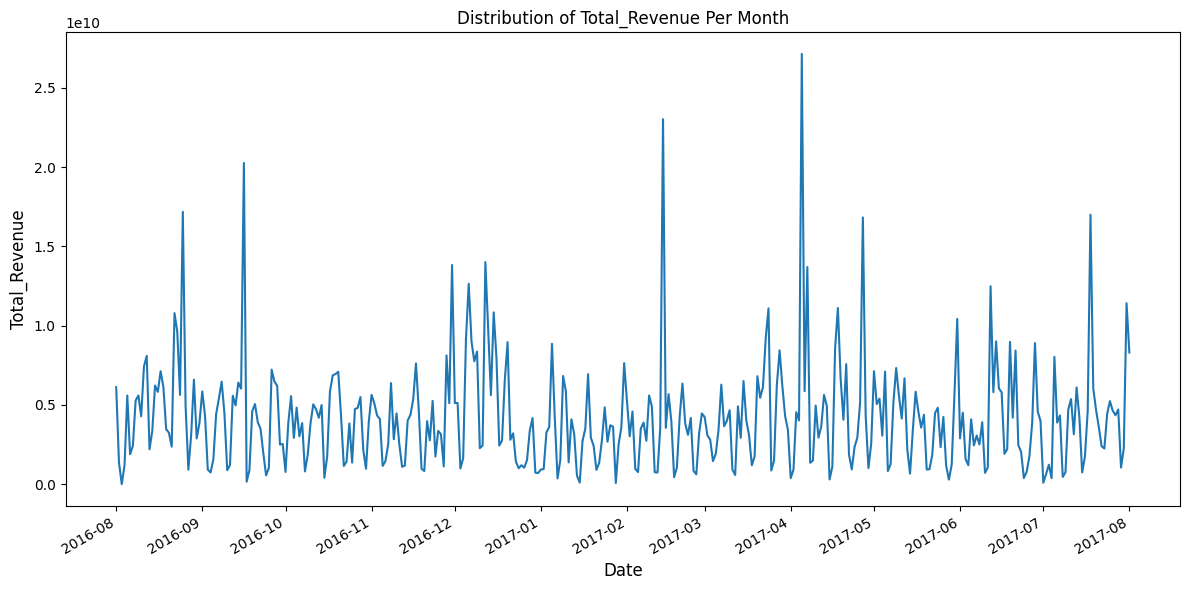

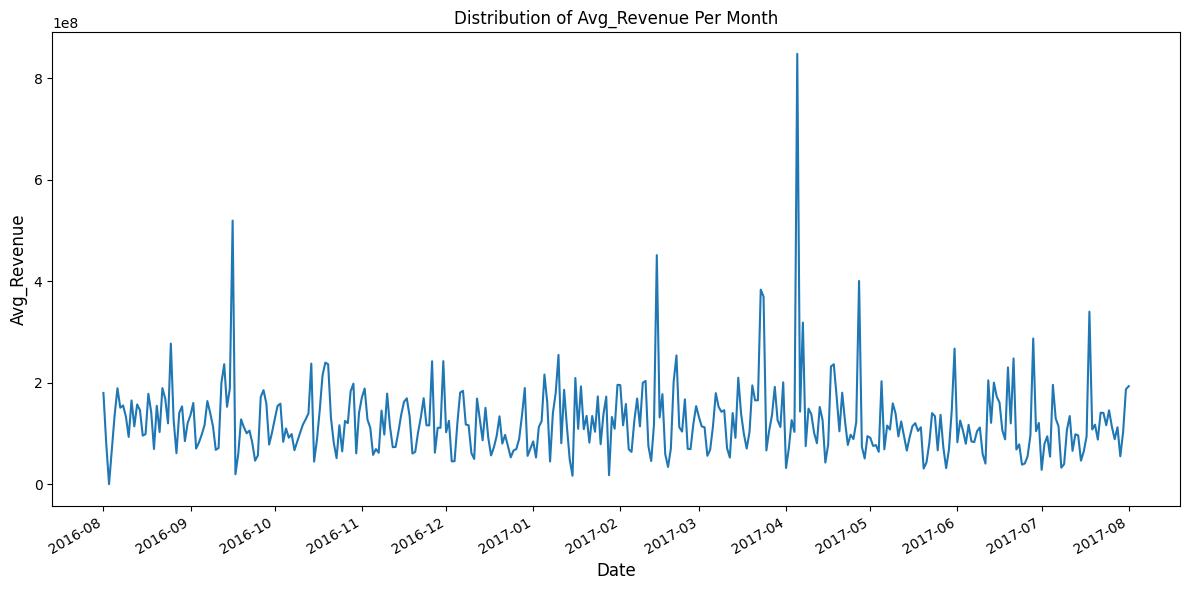

In [10]:
import matplotlib.dates as mdates

revenue_per_date_query = """
SELECT
    PARSE_DATE('%Y%m%d', date) AS DATE,
    COUNT(*) AS VISIT_COUNT,
    COALESCE(SUM(totals.transactionRevenue), 0) AS Total_Revenue,
    COALESCE(AVG(totals.transactionRevenue), 0) AS Avg_Revenue
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY DATE
ORDER BY DATE
"""

revenue_per_date = bq_data.query_to_pandas_safe(revenue_per_date_query)
revenue_per_date['DATE'] = pd.to_datetime(revenue_per_date['DATE'])
for i, col in enumerate(['VISIT_COUNT', 'Total_Revenue', 'Avg_Revenue']):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(revenue_per_date['DATE'], revenue_per_date[col])

    # Format x-axis to show only year and month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

    if col == 'VISIT_COUNT':
        plt.title('Visits Count Per Month')
    else:
        plt.title('Distribution of ' + col + ' Per Month')

    plt.xlabel('Date', fontsize=12)
    plt.ylabel(col, fontsize=12)

    # Rotate and align the tick labels so they look better
    fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()


**Interpretaion**
1. The Visits peak was on 2016-10 to 2016-11. Donald Trump won his first term at that time.
2. The peaks of Total Revenue are on Feb, Apr, Sep. Maybe it's because the holidays. 
3. The peaks of Average Revenue are the same as Total Revenue. 

In [ ]:
import seaborn as sns

def categorical_countplot(feature):
    #this function extract usage count of feature passed using BigQuery and visualize the usage of top 10 feature values based on their counts
    separate_feat = feature.split('.')[1]
    query = """SELECT """ + feature + """, COUNT(*) AS COUNT,coalesce(SUM( totals.transactionRevenue ),0) AS TotalRevenue,
    coalesce(AVG( totals.transactionRevenue ),0) AS AvgRevenue
      FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
      GROUP BY """ + feature + """
      ORDER BY COUNT(*) DESC"""
    feature_count = bq_data.query_to_pandas_safe(query)
    print('Total number of ' ,separate_feat, ' :',len(feature_count[separate_feat]))
    #let's visualize the usage of top 10 feature categories using barplot

    # Create a color palette with distinct colors
    custom_colors = ['#4f4431', '#81683f', '#d59321', '#f8a412', '#3c6891', '#3b7cb7', '#2d84d2', '#1e89ea', '#7536b0', '#7e27d0']

    # Increase figure size for better readability
    plt.figure(figsize=(20, 6))

    for i, col in enumerate(['COUNT', 'TotalRevenue', 'AvgRevenue']):
      ax = plt.subplot(1, 3, i+1)

    # Create the barplot
      bars = ax.bar(range(len(feature_count.head(10))), feature_count[col].head(10), color=custom_colors)

    # Set x-tick labels
      ax.set_xticks(range(len(feature_count.head(10))))
      ax.set_xticklabels(feature_count[separate_feat].head(10), rotation=90)

      if col == 'COUNT':
        plt.title('Visits Count per ' + separate_feat)
      else:
        plt.title(col + ' per ' + separate_feat)

    # Add value labels on top of each bar
      # for bar in bars:
      #   height = bar.get_height()
      #   ax.text(bar.get_x() + bar.get_width()/2., height,
      #           f'{height:.2f}',
      #           ha='center', va='bottom')

    # Adjust y-axis to make room for labels
      plt.ylim(0, max(feature_count[col].head(10)) * 1.1)

# Adjust layout to prevent overlapping
    plt.tight_layout()

# Show the plot
    plt.show()

Total number of  browser  : 54


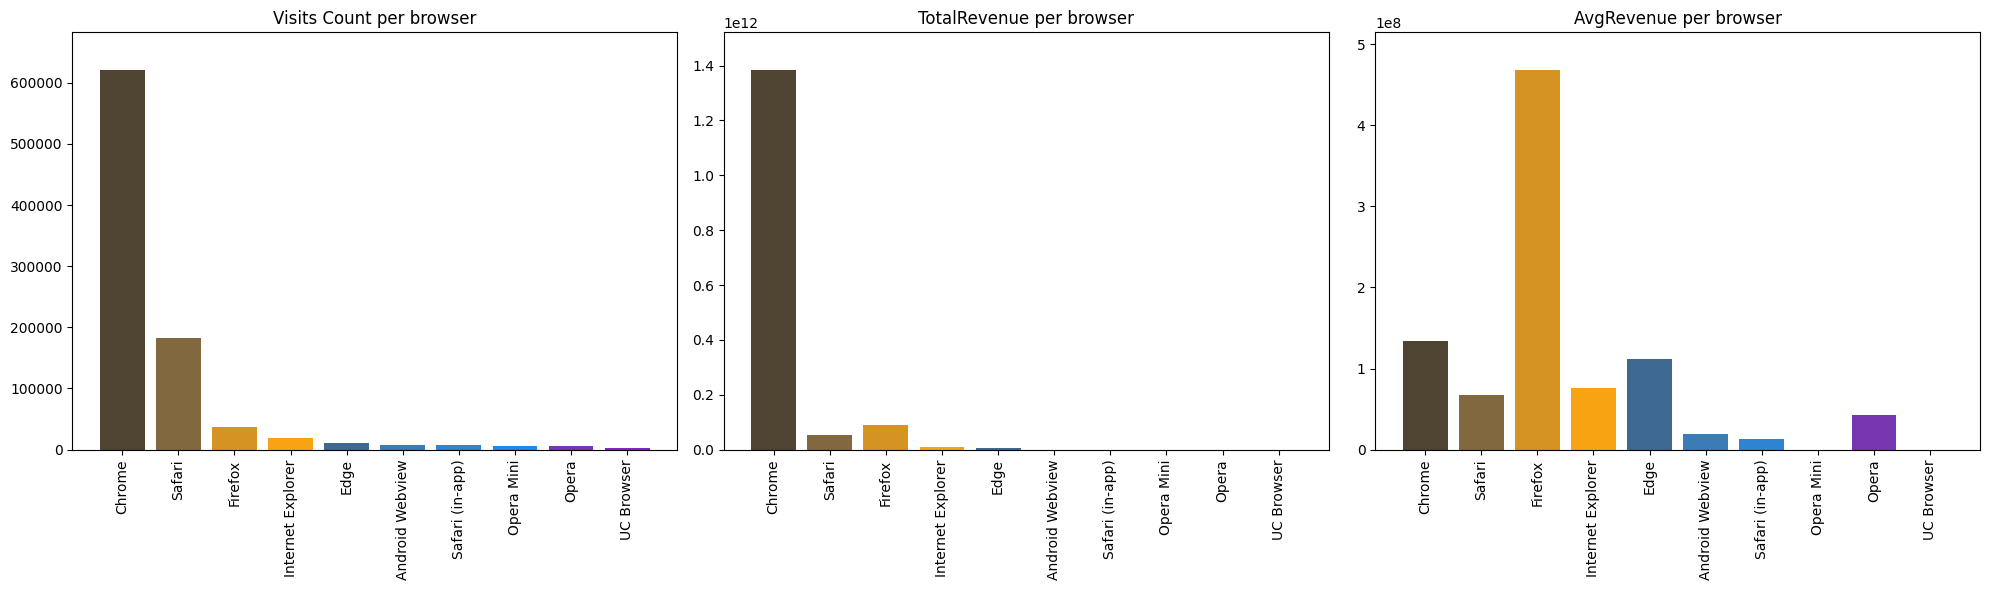

In [ ]:
# exploration of browser variable
categorical_countplot('device.browser')

**Interpretation**
1. Most people use Chrome. 
2. But, the users with high spending use Firefox.

Total number of  operatingSystem  : 20


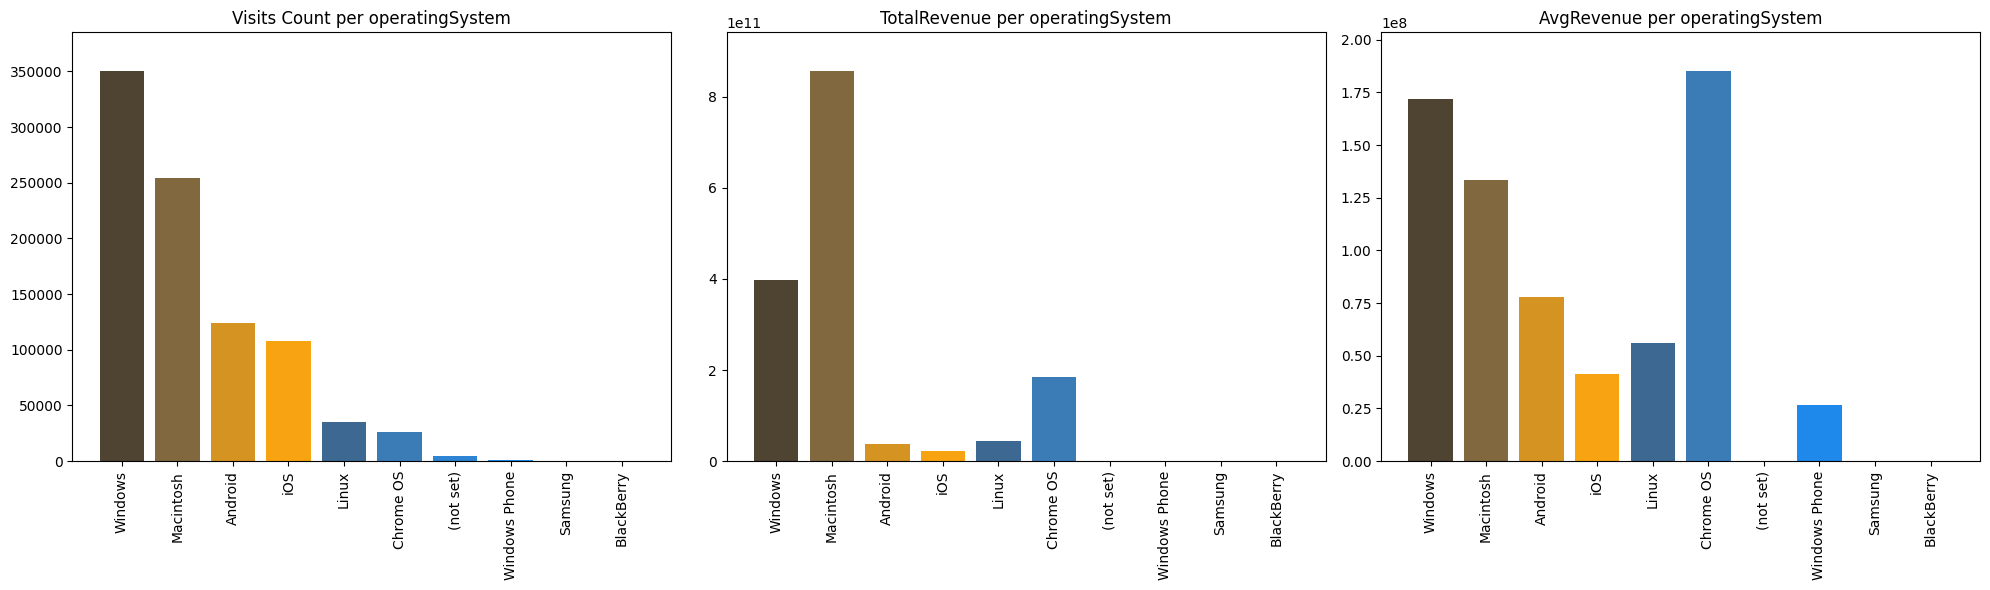

In [ ]:
# exploration of operating system
categorical_countplot('device.operatingSystem')

**Interpretation**
1. Most users use Windows OS.
2. Most Revenue is from Mac users.
3. The rank of quality users is Chrome OS, Windows, and Mac. 

Total number of  deviceCategory  : 3


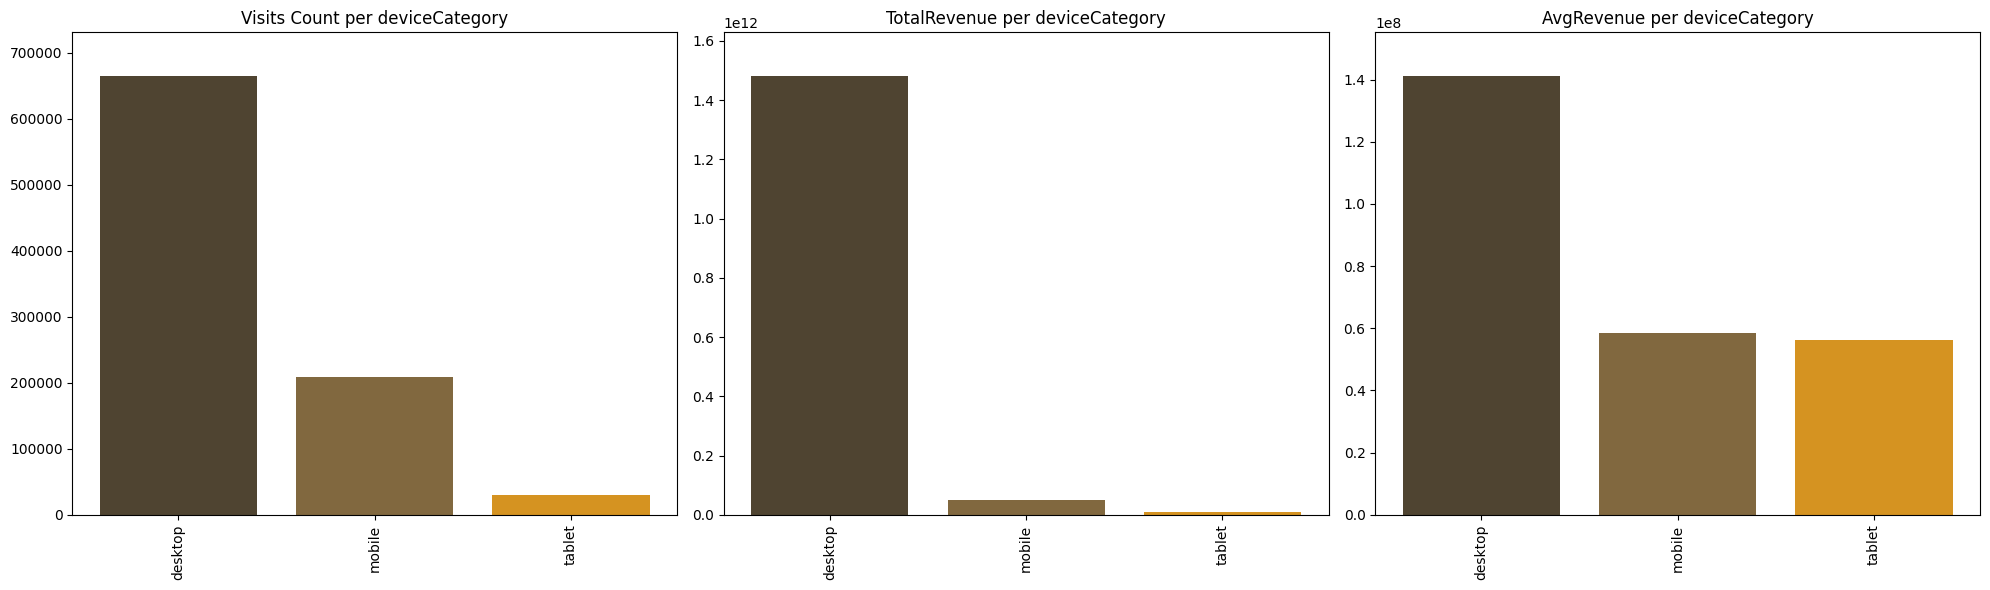

In [ ]:
categorical_countplot('device.deviceCategory')

**Interpretation**
1. Most people use desktop.
2. The users from desktop contribute most total revenue and average revenue. 

Total number of  continent  : 6


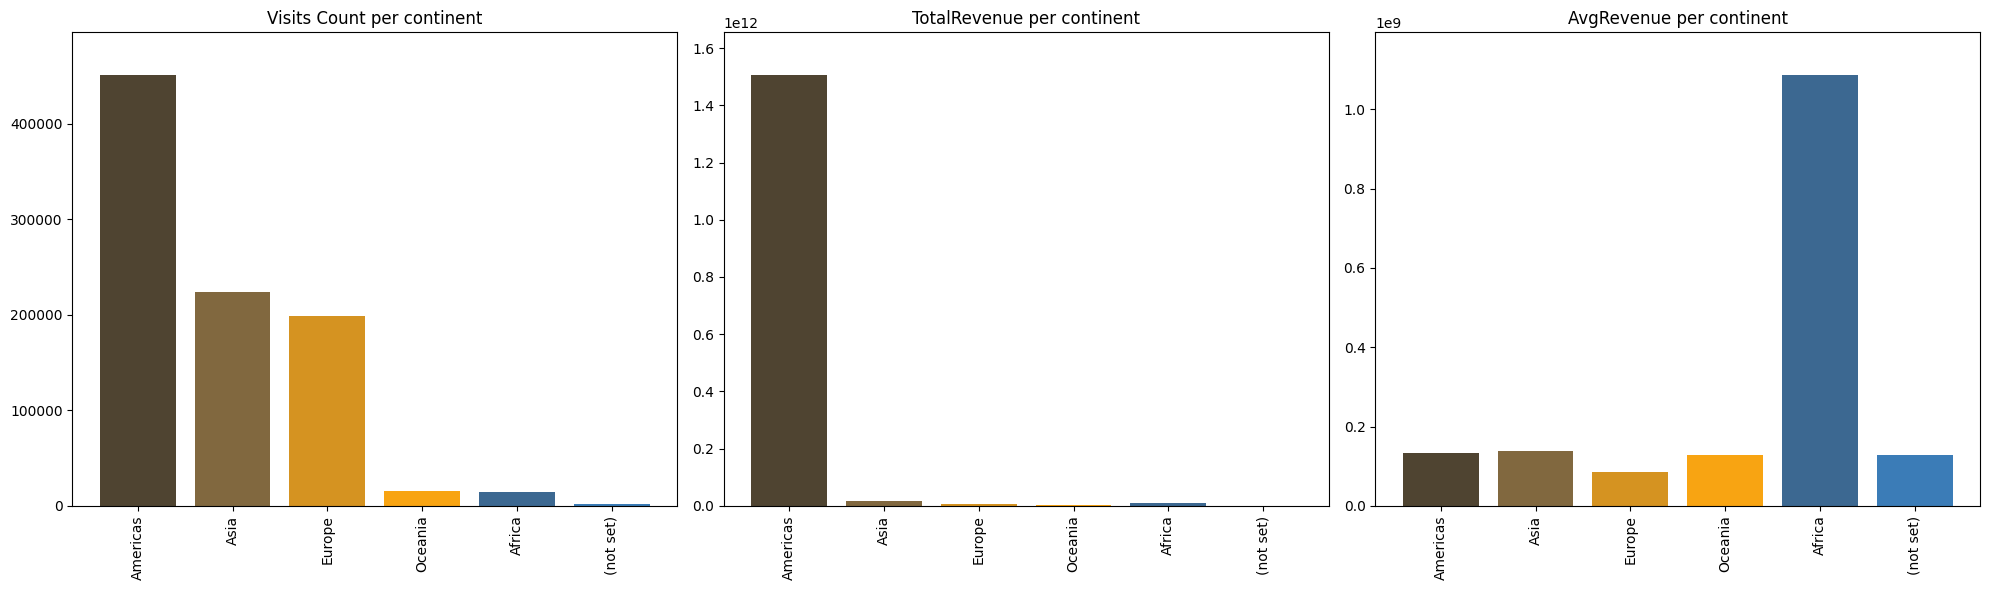

In [ ]:
categorical_countplot('geoNetwork.continent')

**Interpretation**
1. American contribute the most total revenue. 
2. African contribute the most average revenue. 

Total number of  subContinent  : 23


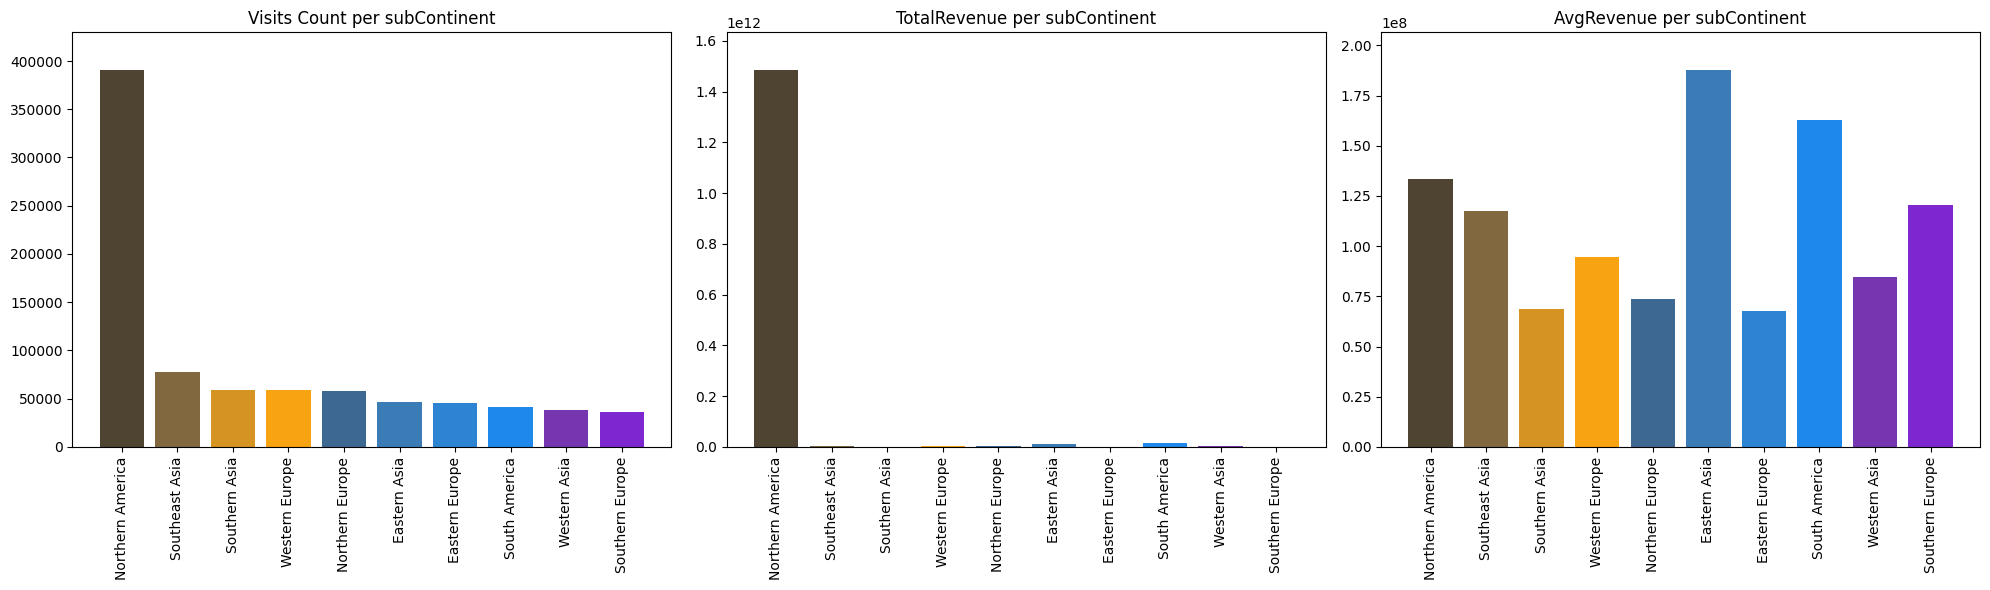

In [ ]:
categorical_countplot('geoNetwork.subContinent')

**Interpretation**
1. Users from Northern America contribute the most total revenue. 
2. But, the top 3 average revenue is from Eastern Asia, South America, Southern Europe.

Total number of  country  : 222


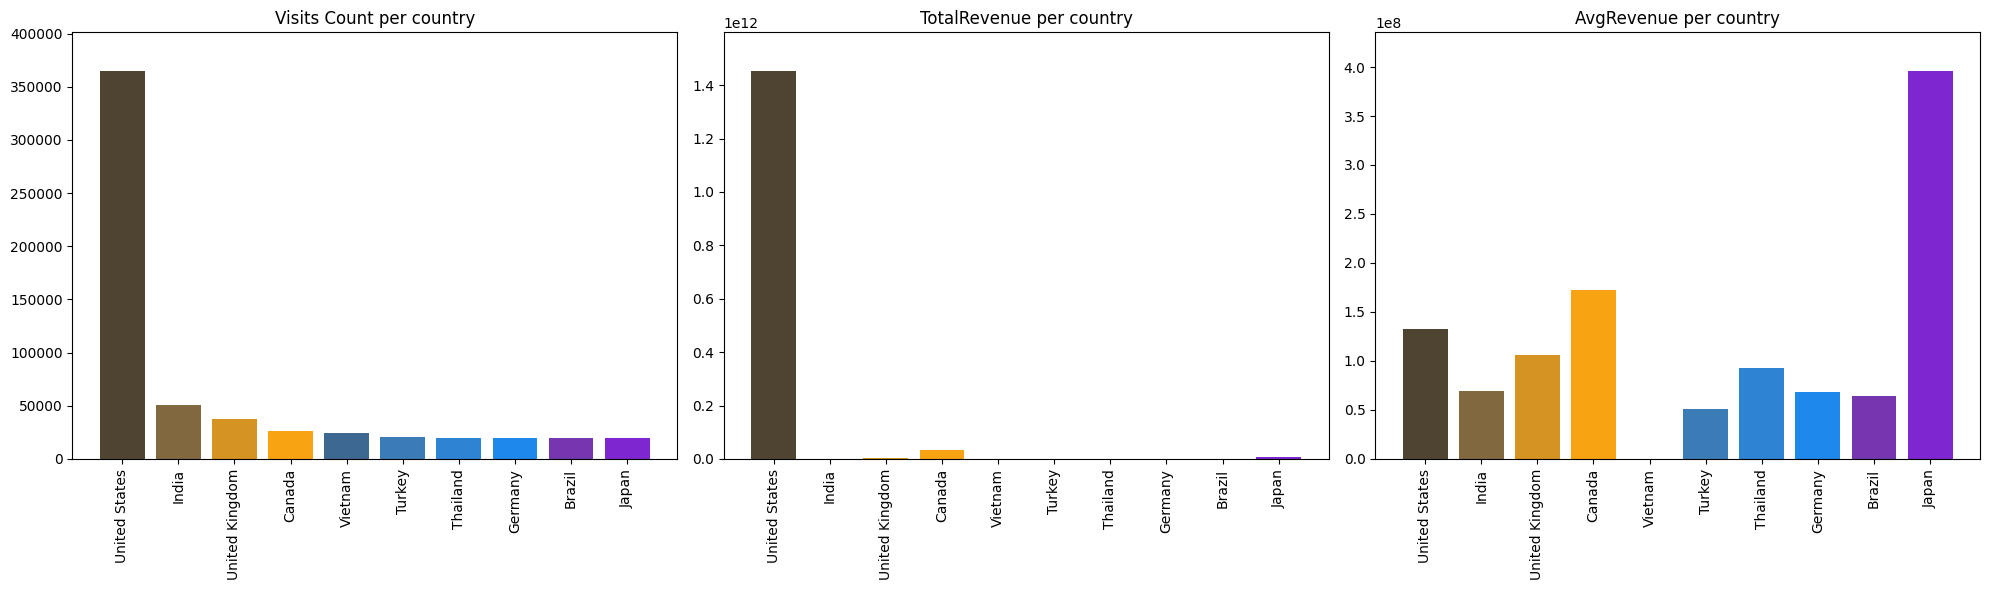

In [ ]:
categorical_countplot('geoNetwork.country')

**Interpretation**
1. US users contribute the most total revenue.
2. However, Japanese users contribute the most average revenue. 

Total number of  source  : 275


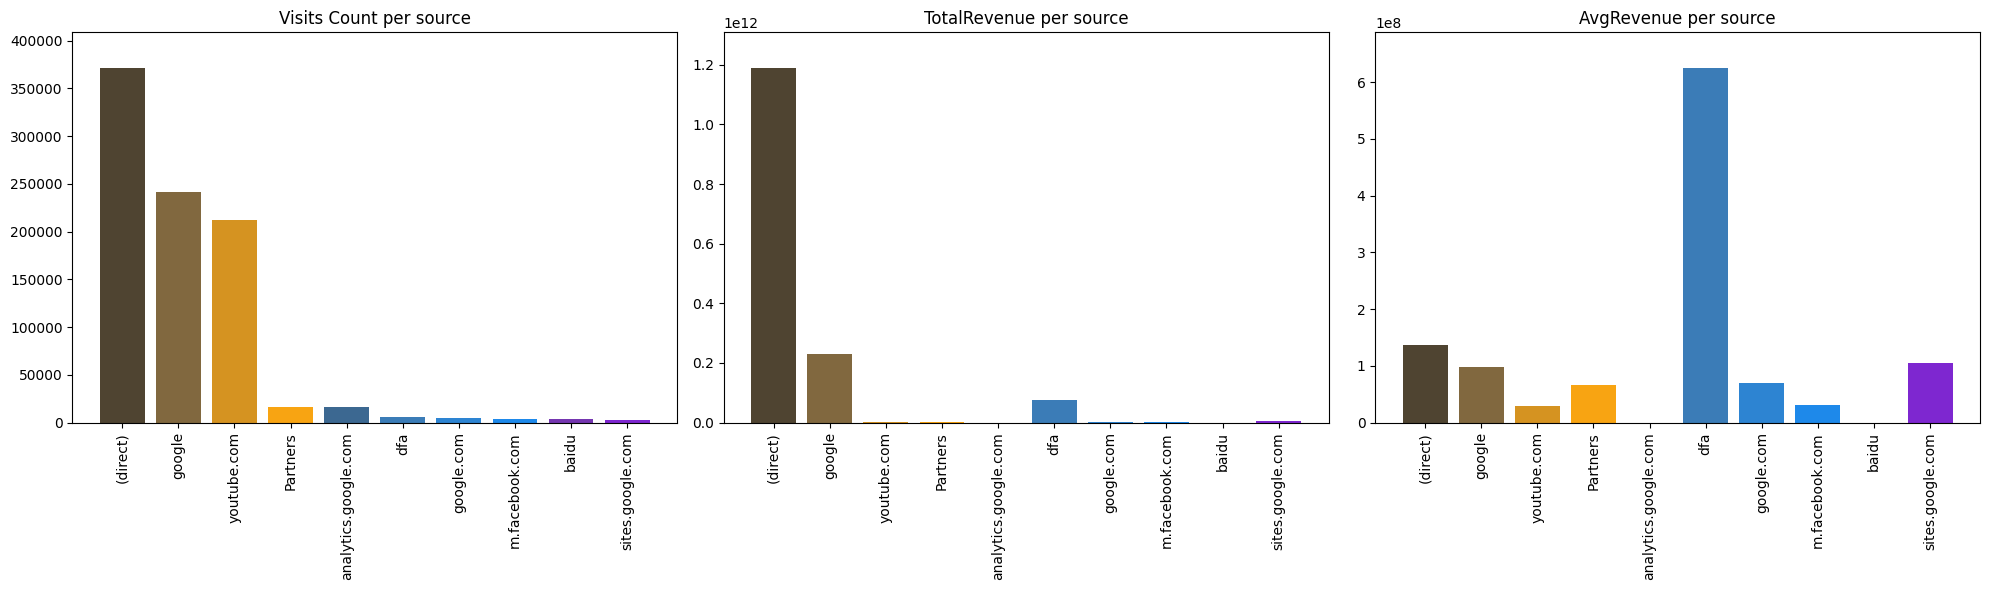

In [ ]:
categorical_countplot('trafficSource.source')

**Interpretation**
1. Direct users contribute the most total revenue. 
2. DoubleClick for Advertisers (DFA) contribute the most average revenue. 

Total number of  medium  : 7


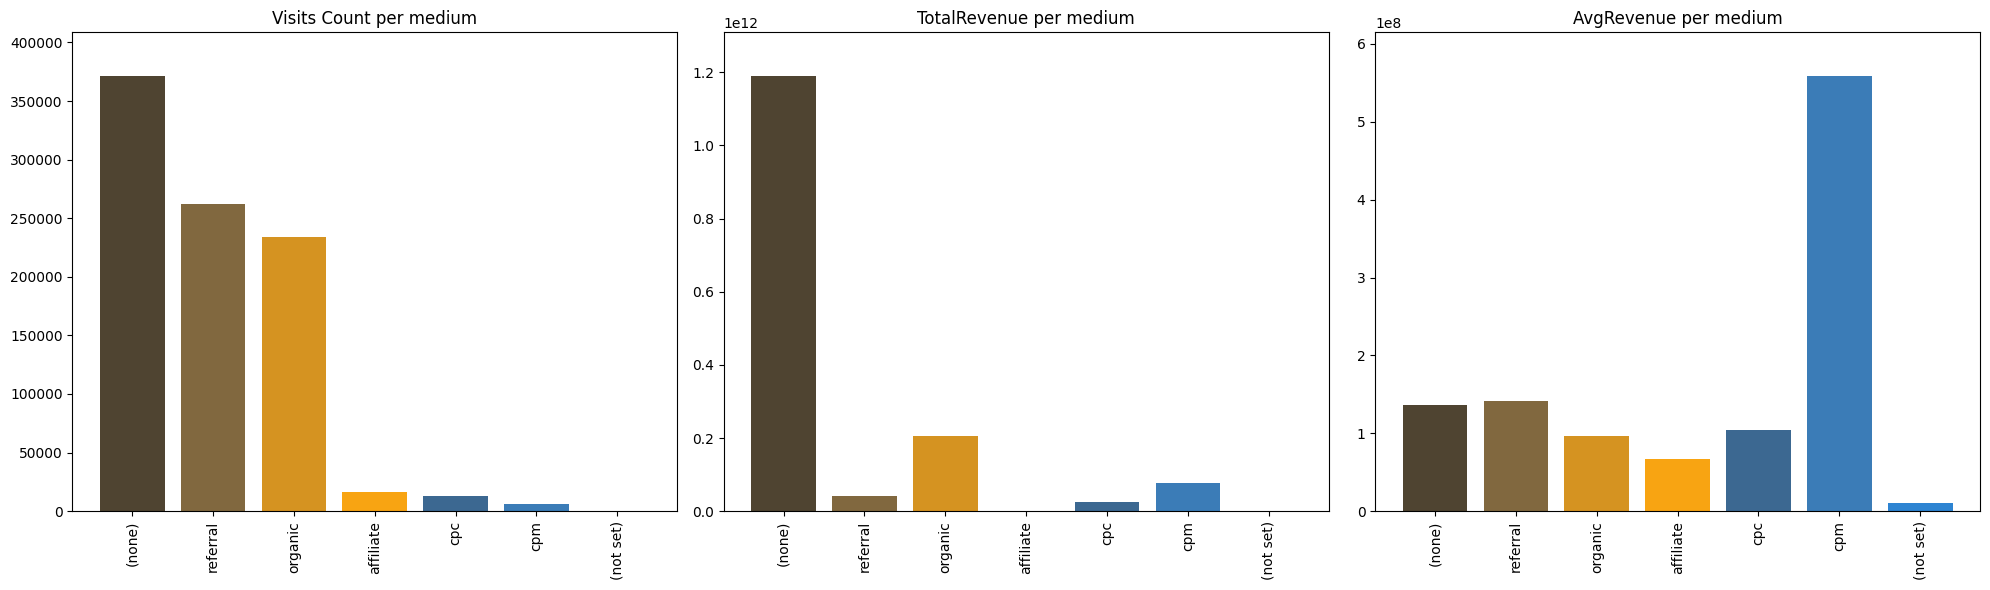

In [ ]:
categorical_countplot('trafficSource.medium')

**Interpretation**
* Organic: This involves the use of all a social media network’s tools that are free at your disposal.
* Paid: On the other hand, paid social refers to all kinds of paid advertising on social media.\
    a. Cost-per-click (CPC)\
    b. Cost-per-mille (CPM): every thousand impressions of an ad are paid, regardless of whether the ad link is clicked or not.

1. Organic contributes the most total revenue. 
2. CPM contributes the most average revenue. 

In [ ]:
hits_query = """
SELECT totals.hits as hits, COUNT(*) AS COUNT,coalesce(SUM( totals.transactionRevenue ),0) AS TotalRevenue,
coalesce(AVG( totals.transactionRevenue ),0) AS AvgRevenue
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY totals.hits ORDER BY totals.hits
  """

hits_count = bq_data.query_to_pandas_safe(hits_query)

Text(0.5, 1.0, 'Visits Count per hits')

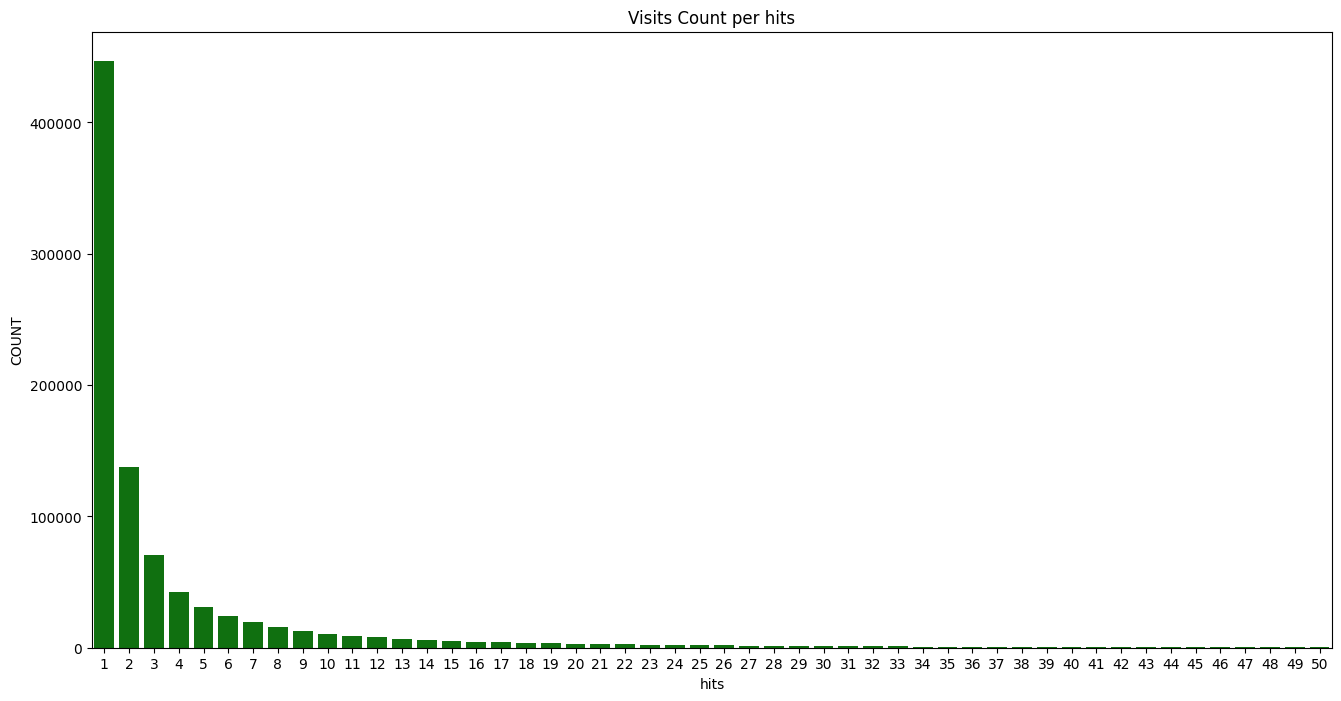

In [ ]:
plt.figure(figsize=(16,8))
sns.barplot(x='hits',y='COUNT',data=hits_count.head(50),color='green')
plt.title('Visits Count per hits')

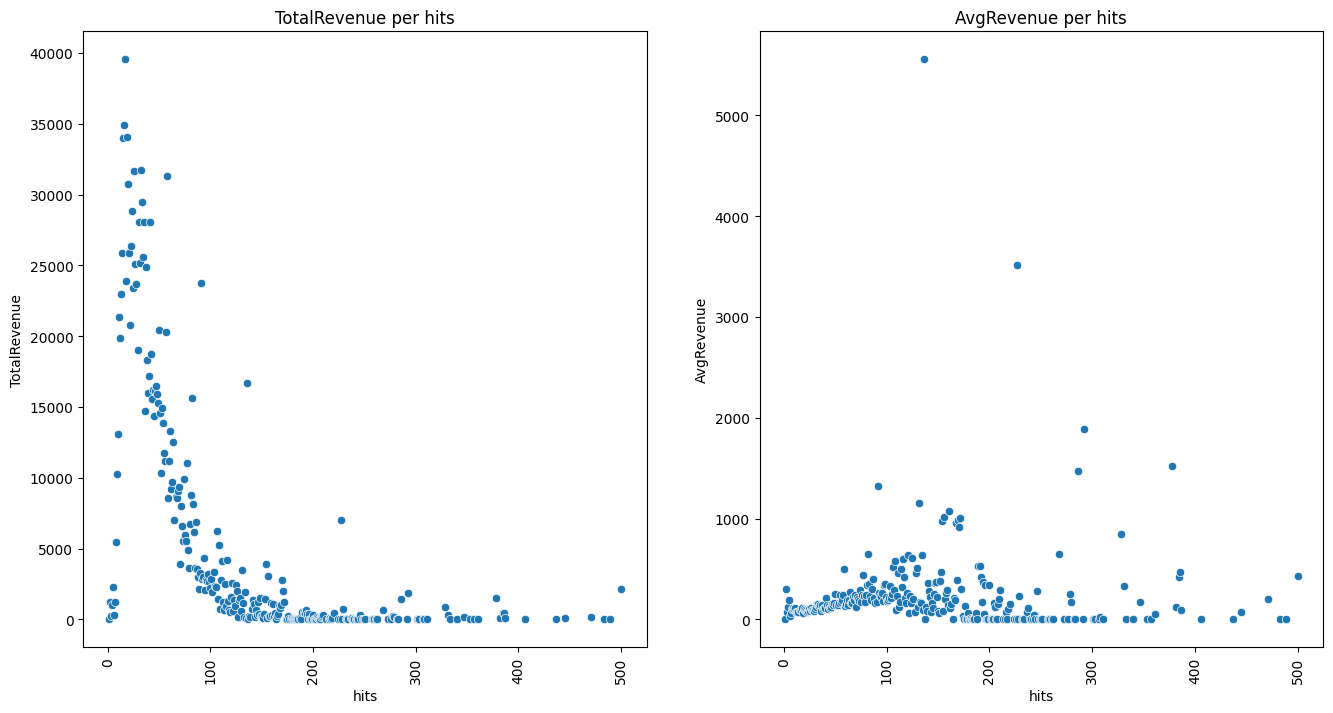

In [ ]:
import matplotlib.ticker as ticker

plt.figure(figsize=(16,8))
for i,col in enumerate(['TotalRevenue','AvgRevenue']) :
        ax = plt.subplot(1,2,i+1)
        sns.scatterplot(x='hits',y=col,data=hits_count)
        plt.title(col + ' per hits')
        scale_y = 1e6
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
        ax.yaxis.set_major_formatter(ticks_y)
        plt.xticks(rotation=90)


**Interpretation**
1. The number of hit increase, the visit, the total revenue and the average revenue would decrease.
2. The visit and the total revenue will decrease in a faster way when hit increase.

In [ ]:
pageviews_query = """
SELECT CAST(totals.pageviews as INT64) as pageviews, COUNT(*) AS COUNT,coalesce(SUM( totals.transactionRevenue ),0) AS TotalRevenue,
coalesce(AVG( totals.transactionRevenue ),0) AS AvgRevenue
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY totals.pageviews 
ORDER BY totals.pageviews
"""

pageviews_count = bq_data.query_to_pandas_safe(pageviews_query)

Text(0.5, 1.0, 'Visit Count per pageviews')

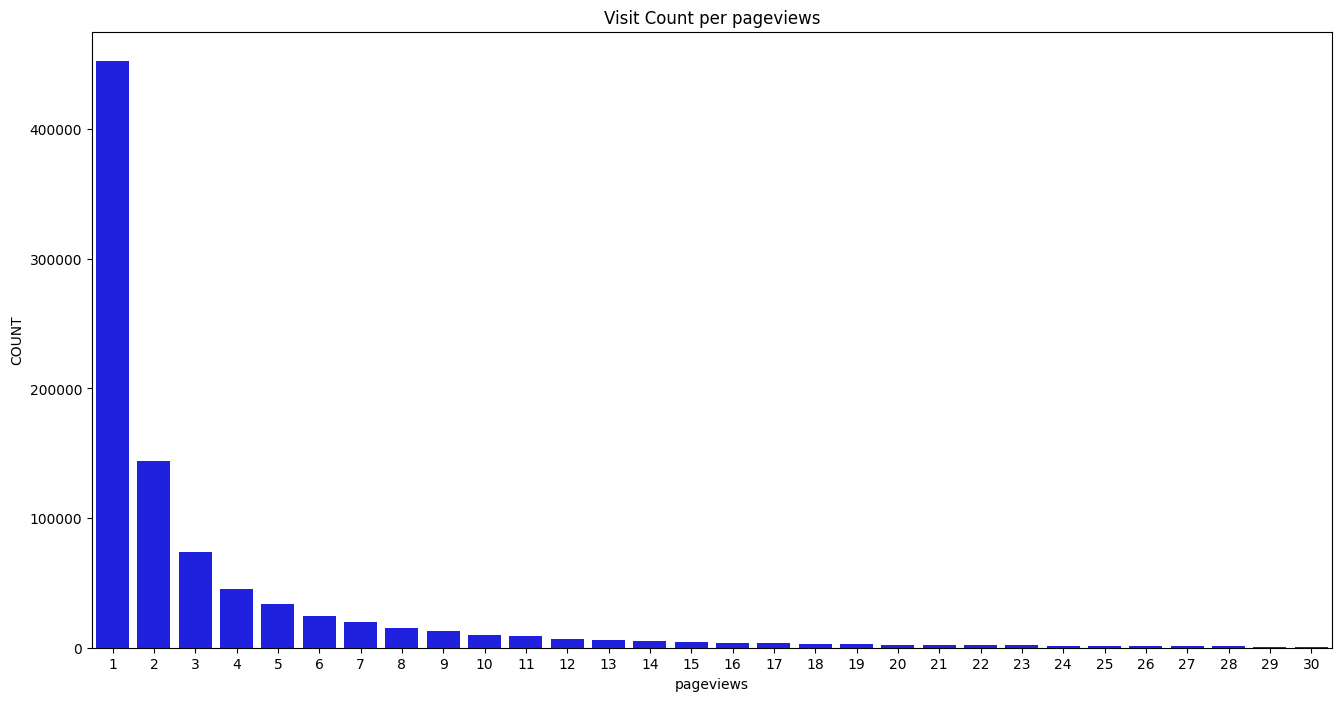

In [ ]:
#pageviews counts

pageviews_count = pageviews_count.dropna()
plt.figure(figsize=(16,8))
sns.barplot(x='pageviews',y='COUNT',data=pageviews_count.head(30),color='blue')
plt.title('Visit Count per pageviews')


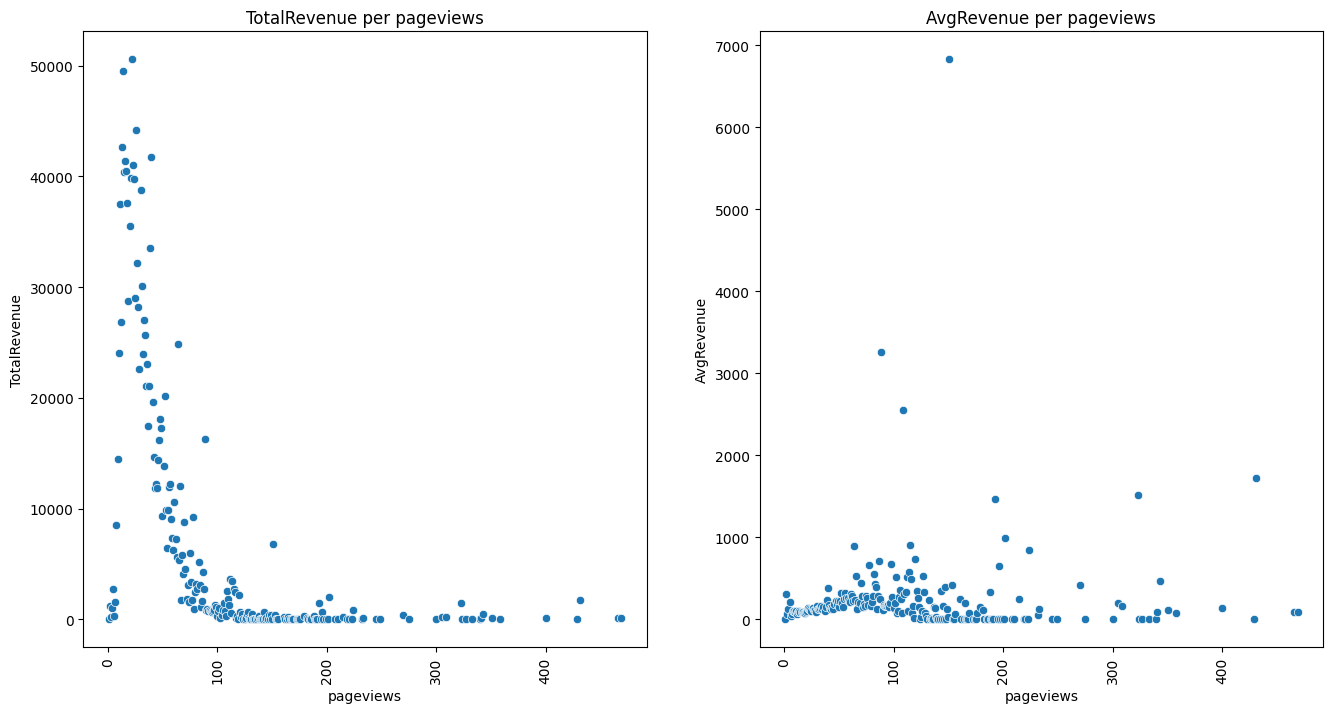

In [ ]:
plt.figure(figsize=(16,8))
for i,col in enumerate(['TotalRevenue','AvgRevenue']) :
        ax = plt.subplot(1,2,i+1)
        sns.scatterplot(x='pageviews',y=col,data=pageviews_count)
        plt.title(col + ' per pageviews')
        scale_y = 1e6
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
        ax.yaxis.set_major_formatter(ticks_y)
        plt.xticks(rotation=90)

**Interpretation**
1. The number of pageview increase, the visit, the total revenue and the average revenue would decrease.
2. The visit and the total revenue will decrease in a faster way when pageview increase.
